---
# Imports
---

In [11]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# Custom module imports
import acquire as a
import prepare as p
import explore as e
import evaluate as ev

# matplotlib settings
plt.rc('font', size=12)
plt.rc('figure', figsize=(15, 7))
pd.options.display.float_format = '{:.2f}'.format

---
# Acquire
---

## full data import

In [41]:
# %%time
# df = pd.read_csv('used_cars_data.csv')

In [43]:
# df.shape

---
Maybe only keep cities with a lot of data in TX
- San Antonio, 
- Houston
- Dallas
- Austin
- El Paso?
- Arlington (is this the Arlington in TX?)
- Fort Worth

In [44]:
# df = df[(df.city == 'San Antonio') |
#         (df.city == 'Houston') |
#         (df.city == 'Dallas') |
#         (df.city == 'Austin') |
#         (df.city == 'El Paso') |
#         (df.city == 'Arlington') |
#         (df.city == 'Fort Worth')]

In [45]:
# df.shape

---
Export .csv here to do rest of work with

In [46]:
# df.to_csv('texas_car_data.csv')

---
## Only TX cars import
---

In [274]:
%%time
df = pd.read_csv('texas_car_data.csv', index_col=0)

CPU times: user 3.19 s, sys: 354 ms, total: 3.54 s
Wall time: 3.59 s


In [ ]:
df = df.reset_index(drop=True) # reset index for this subset of the dataset

In [275]:
df.shape

(122842, 66)

In [276]:
df.head(1)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
139229,JHMFC1F73JX018575,37.4 in,NaN,NaN,NaN,Sedan,NaN,Fort Worth,32.0,NaN,...,CVT,Continuously Variable Transmission,t76411,Touring,NaN,FWD,Front-Wheel Drive,106.3 in,70.8 in,2018


---
# Prepare
---

## Quick clean for MVP (not possible, drops all rows)

In [277]:
# just curious to see if this is even really necessary. How many duplicates even are there?
df.duplicated().sum()

0

In [278]:
df = df.drop_duplicates()

In [279]:
df.shape

(122842, 66)

In [280]:
df.dropna().shape
# cannot drop them all since all rows have at least one null value

(0, 66)

In [281]:
df.shape

(122842, 66)

---

## More nuanced prep involving imputation

In [282]:
def nulls_by_col(df):
    '''
    Takes in df and shows count of how many rows are null and percentage of total rows that are null
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = round(num_missing / rows * 100, 2)
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

In [283]:
nulls_cols = nulls_by_col(df)

In [284]:
nulls_cols[nulls_cols.percent_rows_missing > 50]

,num_rows_missing,percent_rows_missing
bed,121639,99.02
bed_height,104915,85.41
bed_length,104915,85.41
cabin,120703,98.26
combine_fuel_economy,122842,100.00
fleet,62167,50.61
frame_damaged,62167,50.61
has_accidents,62167,50.61
isCab,62167,50.61
is_certified,122842,100.00


In [285]:
nulls_cols[nulls_cols.percent_rows_missing > 50].shape

(16, 2)

**All of these columns will be dropped**

In [286]:
def nulls_by_row(df):
    '''
    Takes in df and shows count of how many columns are null and percentage of total columns that are null and value count of each unique combo
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [287]:
nulls_rows = nulls_by_row(df)

In [288]:
nulls_rows[nulls_rows.percent_cols_missing > 50]

,num_cols_missing,percent_cols_missing,num_rows
30,34,51.52,1131
31,35,53.03,668
32,36,54.55,266
33,37,56.06,322
34,38,57.58,539
35,39,59.09,299
36,40,60.61,54
37,41,62.12,55
38,42,63.64,25


In [289]:
nulls_rows[nulls_rows.percent_cols_missing > 50].num_rows.sum()

3359

**3359 rows will be dropped (if we were looking at original df, but in function, columns are dropped first, so %s will change and less rows will be dropped)**

In [290]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.5):
    '''
    Takes in df and thresholds for null proportions in each column and row and returns df with only columns and rows below threshold
    '''
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [291]:
df.shape

(122842, 66)

In [292]:
%%time
df = handle_missing_values(df)

CPU times: user 417 ms, sys: 39.8 ms, total: 457 ms
Wall time: 461 ms


In [293]:
df.shape

(122816, 50)

In [294]:
122_842 - 122_816

26

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122816 entries, 0 to 122841
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   back_legroom          122816 non-null  float64
 1   body_type             122357 non-null  object 
 2   city                  122816 non-null  object 
 3   city_fuel_economy     103714 non-null  float64
 4   engine_displacement   116188 non-null  float64
 5   franchise_dealer      122816 non-null  int64  
 6   front_legroom         122816 non-null  float64
 7   fuel_tank_volume      122816 non-null  float64
 8   fuel_type             119261 non-null  object 
 9   height                122816 non-null  float64
 10  highway_fuel_economy  103714 non-null  float64
 11  horsepower            116188 non-null  float64
 12  is_new                122816 non-null  int64  
 13  latitude              122816 non-null  float64
 14  length                116916 non-null  float64
 15  

---
#### Initial Ideas/Thoughts about columns:
- VIN
    - Keep as ID? Or just use pandas ID
    - Could use VIN to try to look up vehicle and get more data, but would be beyond scope of this project
    - Drop
- back_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - split, convert to float, impute with mean
- body-type
    - 9 categories
    - keep
- city
    - 7 cities
    - keep
- city_fuel_economy
    - looks like there are some outliers here
    - remove outliers and keep
- daysonmarket
    - Also has outliers (are they?)
    - Should I remove these?
    - Don't think it will be great predictor
    - Keep for now for future feature engineering
    - could be another predictor, but you won't have this until after car is sold, therefore could not be used to predict price
    - drop
- dealer_zip
    - 249 values
    - use lat and long instead or city
    - Drop
- description
    - long text description
    - drop
- engine_cylinders
    - 31 values
    - Maybe simpify just to number of cylinders?
    - Drop for now
    - With more time, I could pull out different categorical/numerical columns from this one column to add features, too much packed into one column
- engine_displacement
    - Maybe some outliers
    - keep for now
- engine_type
    - identical data to engine_cylinders
    - drop for now
- exterior_color
    - 4310 values
    - Could try to clean this column up but would take time
    - drop for now
    - listing color is better
- franchise_dealer
    - no nulls
    - bool
    - keep for now
        - convert to 1 or 0
- franchise_make
    - 39 values
    - The company that owns the franchise (dealership)
    - keep for now
    - Keep top 6 categories and classify all others as "other"
    - drop, other column pertains more pertinent info
- front_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - split, convert to float, impute with mean
- fuel_tank_volume
    - currently string
    - format and convert to float
    - keep converted version
- fuel_type
    - 7 categories
    - Keep for now
    - Maybe narrow down number of categories
        - gas or other?
- height
    - currently string, same process as fuel tank volume
    - keep for now
    - split, convert to float, impute with mean
 - highway_fuel_economy
     - keep
     - maybe remove outliers later
- horsepower
    - keep
    - outliers?
- interior_color
    - 4471 different colors here
    - Could clean up, not for MVP
    - drop
- is_new
    - about 50/50
    - whether or not vehicle waslaunched less than 2 years ago
    - no nulls
    - keep
        - convert to 1 or 0
- latitude
    - keep
- length
    - same process as height and fuel tank volume
    - keep
    - split, convert to float, impute with mean
- listed_date
    - convert to datetime
    - Add to days on market to get date sold
       - all cars were sold in Sep 2020, must have been filter of data being pulled
    - from date sold, create month sold and maybe year sold and add as a new feature
        - not useful since all cars sold on some month of same year
    - drop both columns used after feature is added
    - drop
- listing_color
    - not very many categories
    - keep for now
    - maybe group smaller categories into 'Other'
- listing_id
    - drop
- longitude
    - keep
- main_picture_url
    - url of main listing pic
    - drop
- major_options
    - list of customizable options added (upgrades)
    - can't leave in current format
    - could make new column of length to see how many upgrades each car has
    - could also use in syntax to create more features around whether or not the car has a feature (e.g. cruise control, leather seats, etc.)
    - stored as string
    - drop
    - could revisit and see how to convert to list
- make_name
    - car manufacturer
    - 61 different values
    - pick top groups and group others as 'Other'
    - keep
- maximum_seating
    - keep
    - split, convert to int
    - fill with median or mean
- mileage
    - not sure what is going on with this one
    - keep and remove outliers
- model_name
    - 881 values
    - drop for now
- power
    - combination for hp and rpm
    - info is contained in hp column
    - with more time could normalize and convert into single continuous variable
    - drop for now
- price
    - target
    - drop outliers?
- savings_amount
    - drop
- seller_rating
    - drop
- sp_id
    - drop
- sp_name
    - drop
- torque
    - drop
    - with more time could normalize and convert into single continuous variable
- transmission
    - keep
- transmission_display
    - too many categories
    - drop
- trimId
    - drop
- trim_name
    - drop
- wheel_system
    - keep
- wheel_system_display
    - same info as above
    - drop
- wheelbase
    - same process to pull out number
    - keep for now
- width
    - same process to pull out number
    - keep for now
- year
    - keep
    - outliers?

---

#### scratchpad area

In [708]:
df.year[df.year < 1950]

3589      1940
121414    1923
Name: year, dtype: int64

---
### Choose columns to keep/drop
---

In [812]:
# final list of cols to keep
cols_to_keep = [
    'body_type',
    'city',
    'city_fuel_economy',
    'daysonmarket',
    'engine_displacement',
    'franchise_dealer',
    'franchise_make',
    'fuel_tank_volume',
    'fuel_type',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'latitude',
    'length',
    'listing_color',
    'longitude',
    'make_name',
    'maximum_seating',
    'mileage',
    'transmission',
    'wheel_system',
    'wheelbase',
    'width',
    'year'
]

---

In [771]:
df = pd.read_csv('texas_car_data.csv', index_col=0)
df = df.reset_index(drop=True) # reset index for this subset of the dataset
df = df.drop_duplicates()
df = handle_missing_values(df)

In [772]:
df.shape

(122816, 50)

In [773]:
# back legroom
df.back_legroom = df.back_legroom.str.split(' ', expand=True)[0]
df.back_legroom = pd.to_numeric(df.back_legroom, errors='coerce')
df.back_legroom = df.back_legroom.fillna(round(df.back_legroom.mean(),2))

In [774]:
df.shape

(122816, 50)

In [775]:
# # franchise_make
# top_six = ['Ford', 'Chevrolet', 'Toyota', 'Honda', 'Nissan', 'Jeep']

# df.franchise_make = df.franchise_make.apply(lambda x: x if x in top_six else 'Other')

# # df.franchise_make = np.where(df.franchise_make in top_six, df.franchise_make, 'Other')

In [776]:
df.shape

(122816, 50)

In [777]:
# front legroom
df.front_legroom = df.front_legroom.str.split(' ', expand=True)[0]
df.front_legroom = pd.to_numeric(df.front_legroom, errors='coerce')
df.front_legroom = df.front_legroom.fillna(round(df.front_legroom.mean(),2))

In [778]:
df.shape

(122816, 50)

In [779]:
# franchise_dealer
df.franchise_dealer = np.where(df.franchise_dealer == True, 1, 0)

In [780]:
df.shape

(122816, 50)

In [781]:
# fuel_tank_volume
df.fuel_tank_volume = df.fuel_tank_volume.str.split(' ', expand=True)[0]
df.fuel_tank_volume = pd.to_numeric(df.fuel_tank_volume, errors='coerce')
df.fuel_tank_volume = df.fuel_tank_volume.fillna(round(df.fuel_tank_volume.mean(),2))

In [782]:
df.shape

(122816, 50)

In [783]:
# height
df.height = df.height.str.split(' ', expand=True)[0]
df.height = pd.to_numeric(df.height, errors='coerce')
df.height = df.height.fillna(round(df.height.mean(),2))

In [784]:
df.shape

(122816, 50)

In [785]:
# is_new
df.is_new = np.where(df.is_new == True, 1, 0)

In [786]:
df.shape

(122816, 50)

In [787]:
# length
df.length = df.length.str.split(' ', expand=True)[0]
df.length = pd.to_numeric(df.length, errors='coerce')
df.length = df.length.fillna(round(df.length.mean(),2))

In [788]:
df.shape

(122816, 50)

In [789]:
# # create date sold column
# df.daysonmarket = pd.to_timedelta(df.daysonmarket, unit='D')
# df.listed_date = pd.to_datetime(df.listed_date)
# df['date_sold'] = df.listed_date + df.daysonmarket
# all sold in same year and same month, so this feature is not helpful

In [790]:
# make_name
top_six = ['Ford', 'Chevrolet', 'Toyota', 'Honda', 'Nissan', 'Jeep']
df.make_name = df.make_name.apply(lambda x: x if x in top_six else 'Other')

In [791]:
df.shape

(122816, 50)

In [792]:
# maximum_seating
df.maximum_seating = df.maximum_seating.str.split(' ', expand=True)[0]
df.maximum_seating = pd.to_numeric(df.maximum_seating, errors='coerce')
df.maximum_seating = df.maximum_seating.fillna(df.maximum_seating.median())

In [793]:
df.shape

(122816, 50)

In [794]:
# wheelbase
df.wheelbase = df.wheelbase.str.split(' ', expand=True)[0]
df.wheelbase = pd.to_numeric(df.wheelbase, errors='coerce')
df.wheelbase = df.wheelbase.fillna(round(df.wheelbase.mean(),2))

In [795]:
df.shape

(122816, 50)

In [796]:
# width
df.width = df.width.str.split(' ', expand=True)[0]
df.width = pd.to_numeric(df.width, errors='coerce')
df.width = df.width.fillna(round(df.width.mean(),2))

In [797]:
df.shape

(122816, 50)

In [799]:
# to drop all at once as I go through if I have to reset df
cols_to_drop = [
    'vin', 
    # 'back_legroom',
    'dealer_zip',
    'description',
    'engine_cylinders',
    'engine_type',
    'exterior_color',
    # 'front_legroom',
    'interior_color',
    'interior_color',
    'daysonmarket',
    'listed_date',
    'listing_id',
    'main_picture_url',
    'major_options',
    'franchise_make',
    'model_name',
    'power',
    'savings_amount',
    'seller_rating',
    'sp_id',
    'sp_name',
    'torque',
    'transmission_display',
    'trimId',
    'trim_name',
    'wheel_system_display'
]

# drop all columns above
df = df.drop(columns=cols_to_drop)

In [815]:
df.shape

(122816, 26)

---

#### Numerical 

In [816]:
# pull list of numeric columns based on current formatting
df.select_dtypes('number').columns.tolist()

['back_legroom',
 'city_fuel_economy',
 'engine_displacement',
 'franchise_dealer',
 'front_legroom',
 'fuel_tank_volume',
 'height',
 'highway_fuel_economy',
 'horsepower',
 'is_new',
 'latitude',
 'length',
 'longitude',
 'maximum_seating',
 'mileage',
 'price',
 'wheelbase',
 'width',
 'year']

In [817]:
len(df.select_dtypes('number').columns.tolist())

19

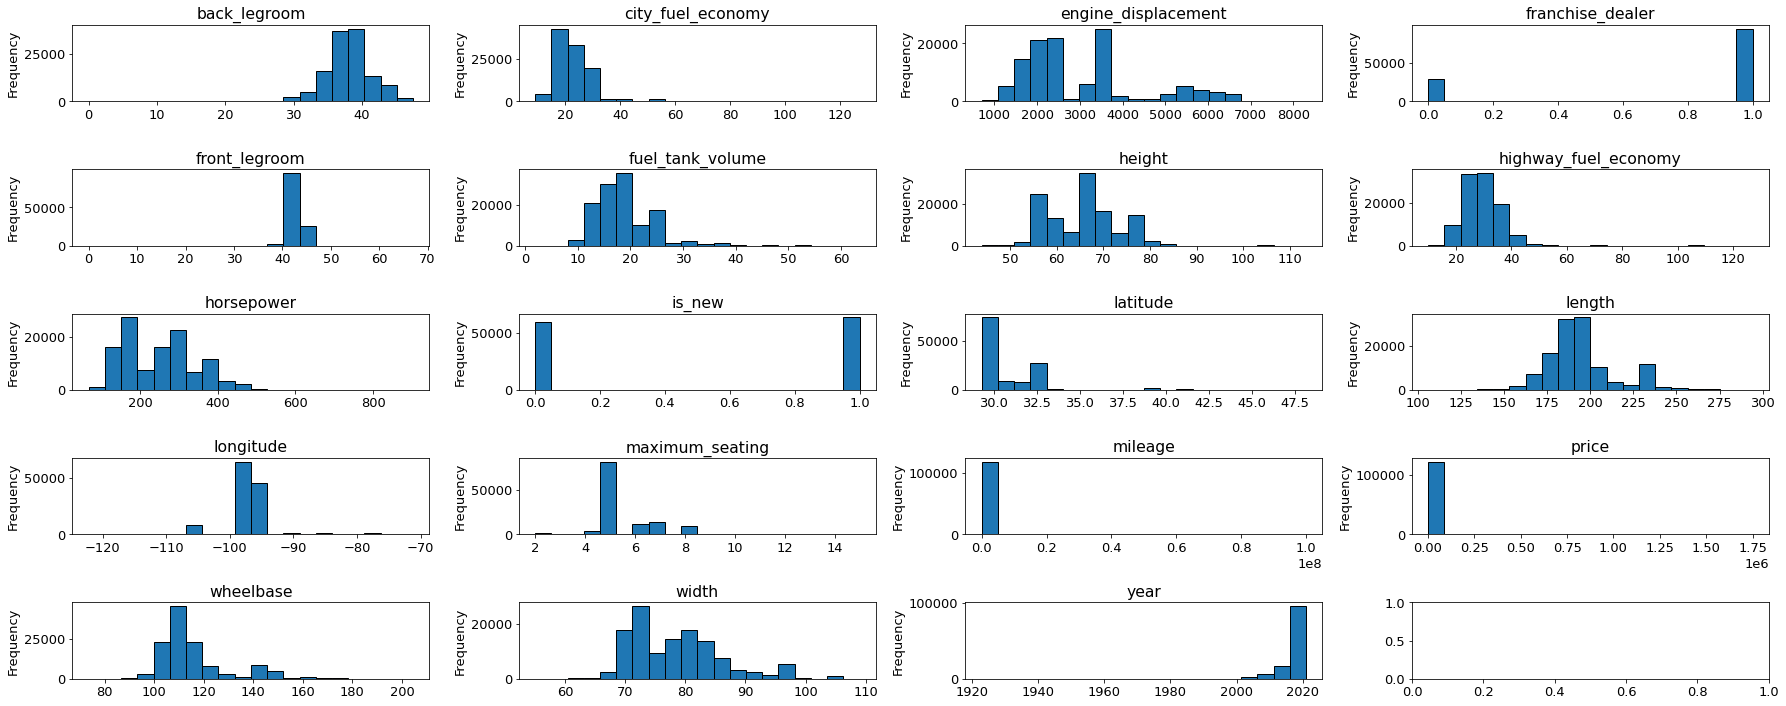

In [818]:
# take a look at remaining column distributions
# let's take a look at the distributions of the continuous variables
fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(df.select_dtypes('number').columns):
    df[c].plot.hist(ax=axe[i],title=c, ec='black', bins=20)
    plt.tight_layout()

#### Categorical 

In [819]:
len(df.select_dtypes('object').columns.tolist())

7

In [820]:
cat_cols = df.select_dtypes('object').columns.tolist()

for cat in cat_cols:
    print(cat)
    print('-----------------')
    print(df[cat].value_counts(normalize=True))
    print('-----------------')


---
#### Bool 
---

In [822]:
len(df.select_dtypes('bool').columns.tolist())

0

In [823]:
bool_cols = df.select_dtypes('bool').columns.tolist()

In [824]:
for col in bool_cols:
    print(col)
    print('-----------------')
    print(df[col].value_counts(normalize=True))
    print('-----------------')

---

In [825]:
len(cols_to_drop)

25

In [826]:
len(cols_to_keep)

24

### Imputation
- impute all with mean or median

In [887]:
df.isna().sum().sort_values(ascending=False)

back_legroom            0
body_type               0
width                   0
wheelbase               0
wheel_system            0
transmission            0
price                   0
mileage                 0
maximum_seating         0
make_name               0
longitude               0
listing_color           0
length                  0
latitude                0
is_new                  0
horsepower              0
highway_fuel_economy    0
height                  0
fuel_type               0
fuel_tank_volume        0
front_legroom           0
franchise_dealer        0
engine_displacement     0
city_fuel_economy       0
city                    0
year                    0
dtype: int64

In [853]:
df.city_fuel_economy = df.city_fuel_economy.fillna(value=round(df.city_fuel_economy.mean(),0))
df.engine_displacement = df.engine_displacement.fillna(value=round(df.engine_displacement.mean(),0))
df.highway_fuel_economy = df.highway_fuel_economy.fillna(value=round(df.highway_fuel_economy.mean(),0))
df.horsepower = df.horsepower.fillna(value=round(df.horsepower.mean(),0))
df.wheel_system = df.wheel_system.fillna(value=df.wheel_system.mode()[0])
df.mileage = df.mileage.fillna(value=round(df.mileage.mean(),0))
df.fuel_type = df.fuel_type.fillna(value=df.fuel_type.mode()[0])
df.transmission = df.transmission.fillna(value=df.transmission.mode()[0])
df.body_type = df.body_type.fillna(value=df.body_type.mode()[0])

### Outliers

In [2]:
df = a.get_tx_car_data()
df = p.clean_cars(df)

In [3]:
df.shape

(91114, 26)

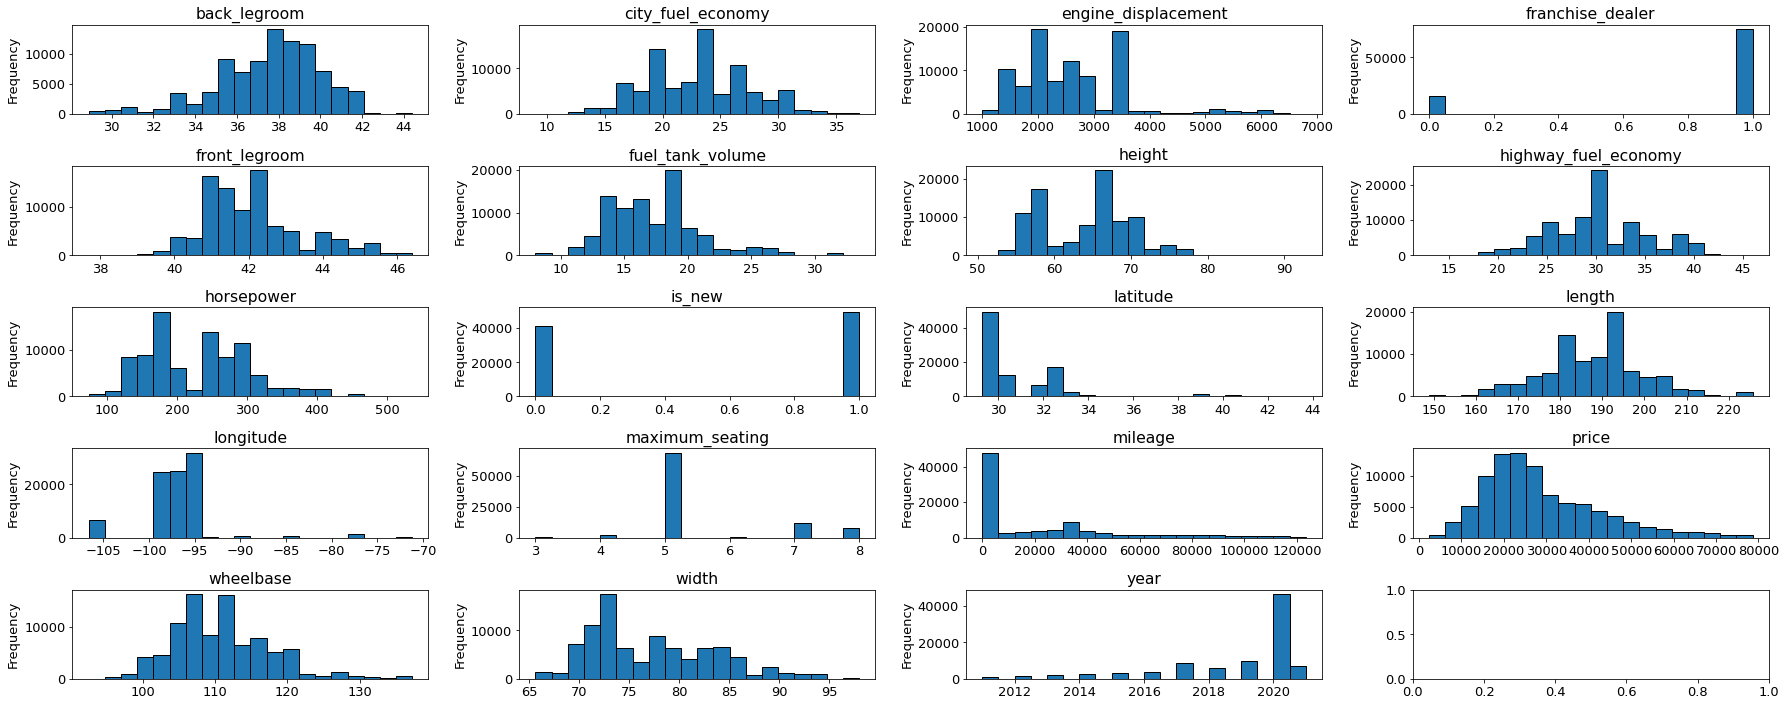

In [4]:
fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(df.select_dtypes('number').columns):
    df[c].plot.hist(ax=axe[i],title=c, ec='black', bins=20)
    plt.tight_layout()

In [7]:
df.describe()

,back_legroom,city_fuel_economy,engine_displacement,franchise_dealer,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,is_new,latitude,length,longitude,maximum_seating,mileage,price,wheelbase,width,year
count,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000,91114.000000
mean,37.580218,22.822409,2631.862151,0.821926,42.070163,17.256845,64.030904,30.274601,230.870360,0.545021,30.856717,188.055819,-97.133384,5.495456,21888.703679,28655.487444,110.864211,77.111042,2018.696325
std,2.475992,4.373612,979.213629,0.382577,1.316780,3.639573,5.769841,4.965003,74.179891,0.497972,1.975055,12.004811,3.930727,1.042829,29919.902419,13619.721779,6.760270,6.231814,2.205097
min,28.900000,9.000000,1000.000000,0.000000,37.700000,8.000000,50.600000,13.000000,74.000000,0.000000,29.291900,148.800000,-106.608000,3.000000,0.000000,2350.000000,92.500000,65.600000,2011.000000
25%,36.100000,19.000000,2000.000000,1.000000,41.100000,14.500000,57.900000,27.000000,170.000000,0.000000,29.638700,181.900000,-98.445400,5.000000,6.000000,18996.000000,106.300000,72.400000,2018.000000
50%,37.990000,23.000000,2500.000000,1.000000,42.000000,17.100000,65.400000,30.000000,240.000000,1.000000,29.912700,189.000000,-97.089900,5.000000,2902.500000,25455.000000,110.500000,75.400000,2020.000000
75%,39.300000,26.000000,3500.000000,1.000000,42.600000,19.000000,68.000000,33.000000,284.000000,1.000000,31.887700,194.200000,-95.551500,5.000000,34198.750000,36011.000000,115.300000,81.900000,2020.000000
max,44.400000,37.000000,6800.000000,1.000000,46.400000,33.500000,92.800000,46.000000,536.000000,1.000000,43.683000,225.700000,-71.173200,8.000000,123401.000000,78630.000000,137.300000,98.000000,2021.000000


In [16]:
cols_w_outliers = [
    'back_legroom', 
    'city_fuel_economy', 
    'engine_displacement', 
    'front_legroom',
    'fuel_tank_volume',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'length',
    'maximum_seating',
    'mileage',
    'price',
    'wheelbase',
    'width',
    'year'
]

In [18]:
df.shape

(122816, 26)

In [19]:
df = p.remove_outliers(df, cols_w_outliers, 2.0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91114 entries, 0 to 122840
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   back_legroom          91114 non-null  float64
 1   body_type             91114 non-null  object 
 2   city                  91114 non-null  object 
 3   city_fuel_economy     91114 non-null  float64
 4   engine_displacement   91114 non-null  float64
 5   franchise_dealer      91114 non-null  int64  
 6   front_legroom         91114 non-null  float64
 7   fuel_tank_volume      91114 non-null  float64
 8   fuel_type             91114 non-null  object 
 9   height                91114 non-null  float64
 10  highway_fuel_economy  91114 non-null  float64
 11  horsepower            91114 non-null  float64
 12  is_new                91114 non-null  int64  
 13  latitude              91114 non-null  float64
 14  length                91114 non-null  float64
 15  listing_color     

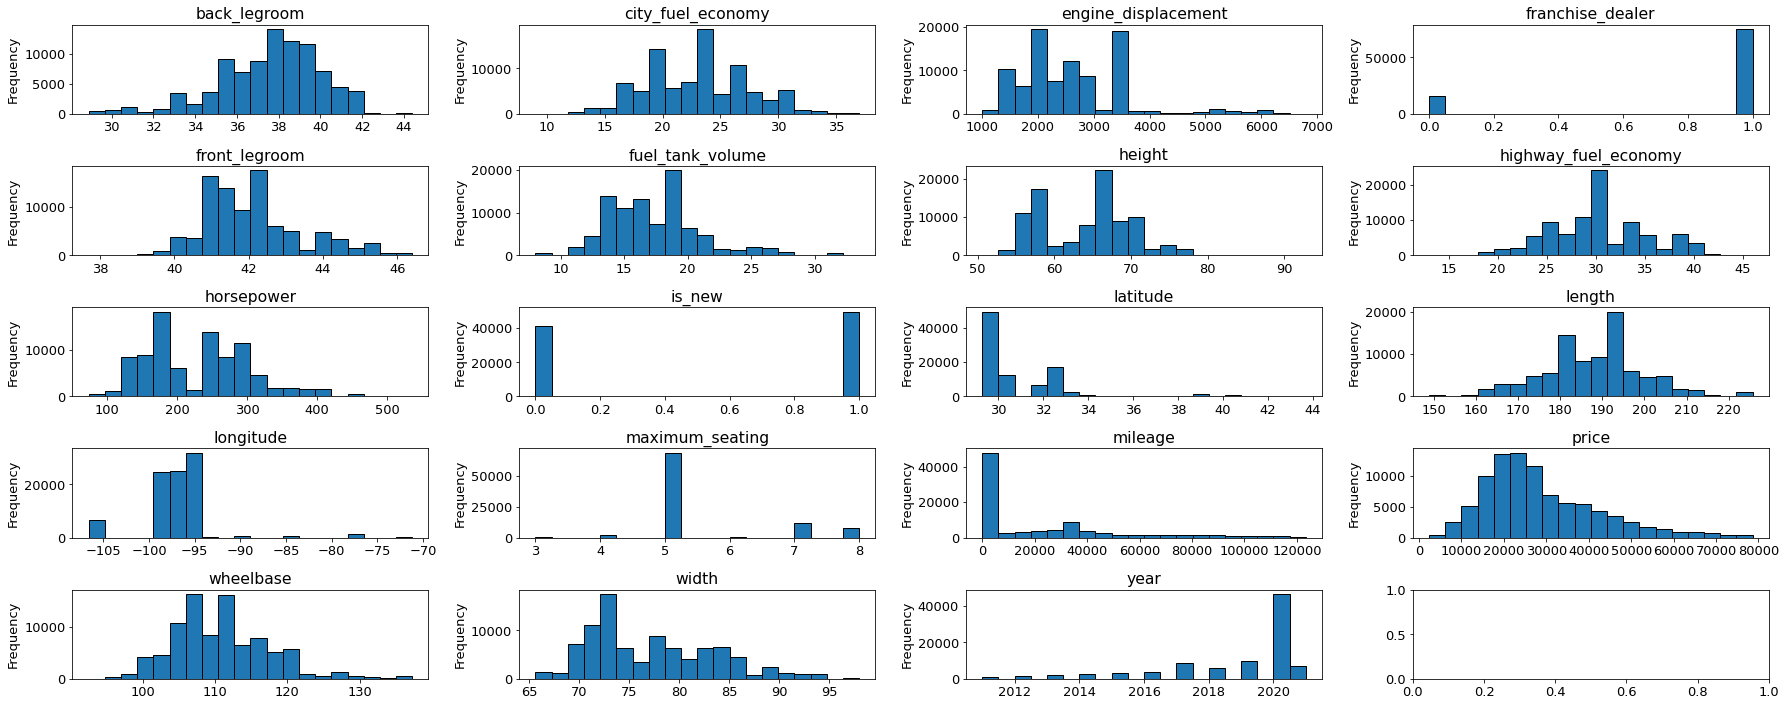

body_type
-----------------
SUV / Crossover    0.558849
Sedan              0.301951
Pickup Truck       0.042255
Coupe              0.028239
Minivan            0.028141
Hatchback          0.023772
Wagon              0.009614
Convertible        0.004138
Van                0.003040
Name: body_type, dtype: float64
-----------------

city
-----------------
Houston        0.350649
San Antonio    0.214588
Austin         0.117885
Dallas         0.113517
El Paso        0.081184
Arlington      0.066828
Fort Worth     0.055348
Name: city, dtype: float64
-----------------

fuel_type
-----------------
Gasoline                  0.961839
Flex Fuel Vehicle         0.025748
Diesel                    0.005586
Hybrid                    0.004654
Electric                  0.001558
Biodiesel                 0.000582
Compressed Natural Gas    0.000033
Name: fuel_type, dtype: float64
-----------------

listing_color
-----------------
WHITE      0.204217
BLACK      0.202230
UNKNOWN    0.144819
GRAY       0.136

In [2]:
df = a.get_tx_car_data()
df = p.clean_cars(df)

fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(df.select_dtypes('number').columns):
    df[c].plot.hist(ax=axe[i],title=c, ec='black', bins=20)
    plt.tight_layout()
plt.show()
    
cat_cols = df.select_dtypes('object').columns.tolist()

for cat in cat_cols:
    print(cat)
    print('-----------------')
    print(df[cat].value_counts(normalize=True))
    print('-----------------\n')
    

### Encode 

In [3]:
df.shape

(91114, 26)

In [9]:
cat_cols

['body_type',
 'city',
 'fuel_type',
 'listing_color',
 'make_name',
 'transmission',
 'wheel_system']

In [4]:
df_encoded = pd.get_dummies(data=df, columns=cat_cols)
df_encoded.head().T

,0,1,2,4,5
back_legroom,37.4,34.5,35.5,32.9,36.2
city_fuel_economy,32.0,27.0,29.0,23.0,30.0
engine_displacement,1500.0,1500.0,2000.0,4000.0,1800.0
franchise_dealer,0.0,1.0,0.0,0.0,0.0
front_legroom,42.3,41.3,41.1,41.7,42.0
...,...,...,...,...,...
wheel_system_4WD,0.0,0.0,0.0,1.0,0.0
wheel_system_4X2,0.0,0.0,0.0,0.0,0.0
wheel_system_AWD,0.0,0.0,0.0,0.0,0.0
wheel_system_FWD,1.0,1.0,1.0,0.0,1.0


In [5]:
df_encoded.shape

(91114, 73)

### Modeling Split 

In [38]:
train_mod, val_mod, test_mod = p.split_80(df_encoded)

Train Proportion: 0.80 (72981 rows)
Validate Proportion: 0.10 (9021 rows)    
Test Proportion: 0.10 (9112 rows)


### Exploration Split 

In [8]:
train_exp, val_exp, test_exp = p.split_80(df)

Train Proportion: 0.80 (72981 rows)
Validate Proportion: 0.10 (9021 rows)    
Test Proportion: 0.10 (9112 rows)


### Scale Modeling Splits

In [39]:
def scale(train, validate, test, scaler, cols_to_scale):
    '''
    Returns dfs with indicated columns scaled using scaler passed and original columns dropped
    '''
    new_column_names = [col + '_scaled' for col in cols_to_scale]
    
    # Fit the scaler on the train
    scaler.fit(train[cols_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[cols_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[cols_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[cols_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    # drop scaled columns
    train = train.drop(columns=cols_to_scale)
    validate = validate.drop(columns=cols_to_scale)
    test = test.drop(columns=cols_to_scale)
    
    return train, validate, test

In [12]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72981 entries, 103196 to 91961
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   back_legroom                      72981 non-null  float64
 1   city_fuel_economy                 72981 non-null  float64
 2   engine_displacement               72981 non-null  float64
 3   franchise_dealer                  72981 non-null  int64  
 4   front_legroom                     72981 non-null  float64
 5   fuel_tank_volume                  72981 non-null  float64
 6   height                            72981 non-null  float64
 7   highway_fuel_economy              72981 non-null  float64
 8   horsepower                        72981 non-null  float64
 9   is_new                            72981 non-null  int64  
 10  latitude                          72981 non-null  float64
 11  length                            72981 non-null  float64
 12 

In [28]:
cols_to_scale = train_mod.select_dtypes('float').columns.tolist()
cols_to_scale.remove('price')
cols_to_scale.append('year')
cols_to_scale

['back_legroom',
 'city_fuel_economy',
 'engine_displacement',
 'front_legroom',
 'fuel_tank_volume',
 'height',
 'highway_fuel_economy',
 'horsepower',
 'latitude',
 'length',
 'longitude',
 'maximum_seating',
 'mileage',
 'wheelbase',
 'width',
 'year']

In [40]:
cols_to_scale = [
    'back_legroom',
    'city_fuel_economy',
    'engine_displacement',
    'front_legroom',
    'fuel_tank_volume',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'latitude',
    'length',
    'longitude',
    'maximum_seating',
    'mileage',
    'wheelbase',
    'width',
    'year']

In [41]:
train_mod_scaled, val_mod_scaled, test_mod_scaled = scale(train_mod, val_mod, test_mod, MinMaxScaler(), cols_to_scale)

In [42]:
train_mod_scaled.head()

,franchise_dealer,is_new,price,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,...,highway_fuel_economy_scaled,horsepower_scaled,latitude_scaled,length_scaled,longitude_scaled,maximum_seating_scaled,mileage_scaled,wheelbase_scaled,width_scaled,year_scaled
103196,1,1,24832.00,0,0,0,0,0,0,1,...,0.61,0.33,0.03,0.47,0.31,0.40,0.00,0.29,0.16,0.90
36985,0,0,16998.00,0,0,0,1,0,0,0,...,0.15,0.45,0.06,0.71,0.25,0.80,0.40,0.64,0.71,0.80
107410,1,1,35603.00,0,0,0,0,0,0,1,...,0.48,0.42,0.02,0.55,0.32,0.40,0.00,0.43,0.25,0.90
19908,0,0,8990.00,0,0,1,0,0,0,0,...,0.70,0.14,0.07,0.17,0.25,0.40,0.52,0.19,0.04,0.60
35809,1,1,23352.00,0,0,0,0,0,0,1,...,0.82,0.16,0.03,0.47,0.23,0.40,0.00,0.29,0.16,0.90
